In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import time
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

# 警告を非表示にする
warnings.filterwarnings("ignore")

In [4]:
# 処理対象のティッカー一覧
tickers = [
    "^N225",
    "^TOPX",
    "7203.T",  # トヨタ
    "6758.T",  # SONY
    "9434.T",  # ソフトバンク
    "6502.T",  # 東芝
    "8306.T",  # 三菱UFJ
    "6501.T",  # 日立
    "6861.T",  # キーエンス
    "6098.T",  # リクルート
    "9983.T",  # ファストリ
    "9432.T"   # NTT
]

# 特徴量セット定義（名称を付けて管理）
feature_sets = {
    "Set1": [
        "LogDiff_Open", "LogDiff_High", "LogDiff_Low", "LogDiff_Close", "LogDiff_Volume",
        "Close_diff_2", "Close_diff_4", "Close_diff_8", "Close_diff_16"
    ],
    "Set2": [
        "LogDiff_Open", "LogDiff_High", "LogDiff_Low", "LogDiff_Close", "LogDiff_Volume",
        "w_1", "v_1", "w_2", "v_2", "w_3", "v_3", "w_4", "v_4"
    ],
    "Set3": [
        "Close_diff_2", "Close_diff_4", "Close_diff_8", "Close_diff_16"
    ],
    "Set4": [
        "w_1", "v_1", "w_2", "v_2", "w_3", "v_3", "w_4", "v_4"
    ]
}

# 日付範囲
start = "2009-01-01"
end = "2023-12-31"

# 結果格納用リスト
results = []

# 処理開始
overall_start_time = time.time()



for ticker in tickers:
    try:
        print(f"Processing ticker: {ticker}...")
        ticker_start_time = time.time()

        # データ取得
        stock = yf.Ticker(ticker)
        data_master = stock.history(start=start, end=end)

        # 欠損値除去
        data = data_master.dropna().copy()

        # 対数差分計算用関数
        def log_diff(series):
            return np.log(series) - np.log(series.shift(1))

        # OHLCVに対して対数差分を計算
        data["LogDiff_Open"] = log_diff(data["Open"])
        data["LogDiff_High"] = log_diff(data["High"])
        data["LogDiff_Low"] = log_diff(data["Low"])
        data["LogDiff_Close"] = log_diff(data["Close"])
        data["LogDiff_Volume"] = log_diff(data["Volume"])

        # 終値の階差特徴量
        data["Close_diff_2"] = data["Close"] - data["Close"].shift(2)
        data["Close_diff_4"] = data["Close"] - data["Close"].shift(4)
        data["Close_diff_8"] = data["Close"] - data["Close"].shift(8)
        data["Close_diff_16"] = data["Close"] - data["Close"].shift(16)

        # ラベル作成
        data["future_close"] = data["Close"].shift(-16)
        data["next_open"] = data["Open"].shift(-15)
        data["y_label"] = (data["future_close"] > data["next_open"]).astype(int)

        # Haarフィルター定義
        h = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
        g = np.array([1/np.sqrt(2), -1/np.sqrt(2)])

        v_current = data["Close"].values
        N = len(v_current)
        max_level = 4

        def line_index_for_level(j, t):
            return (2**j - 1) + (2**j)*t

        for j in range(1, max_level+1):
            length_prev = len(v_current)
            length_new = length_prev // 2

            v_j = np.zeros(length_new)
            w_j = np.zeros(length_new)

            for t in range(length_new):
                v_j[t] = g[0]*v_current[2*t] + g[1]*v_current[2*t+1]
                w_j[t] = h[0]*v_current[2*t] + h[1]*v_current[2*t+1]

            w_col = np.full(N, np.nan)
            v_col = np.full(N, np.nan)

            for t in range(length_new):
                idx = line_index_for_level(j, t)
                if idx < N:
                    w_col[idx] = w_j[t]
                    v_col[idx] = v_j[t]
                else:
                    break

            data[f"w_{j}"] = w_col
            data[f"v_{j}"] = v_col

            v_current = v_j

        # 不要列削除
        data = data.drop(columns=["future_close", "next_open"])
        # 前方補間
        data = data.ffill()

        # InfをNaNに
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        # NaNを0で埋める
        data = data.fillna(0)

        X_all = data
        y = data["y_label"].values

        # 分割器
        tscv = TimeSeriesSplit(n_splits=30)

        # 特徴量セット毎に評価
        for set_name, feature_cols in feature_sets.items():
            print(f"  Evaluating feature set: {set_name}...")
            feature_start_time = time.time()

            # 特徴量列が存在するか確認
            missing_cols = [col for col in feature_cols if col not in data.columns]
            if missing_cols:
                print(f"  Missing columns in feature set {set_name}: {missing_cols}")
                continue  # スキップ

            # 特徴量抽出
            X = X_all[feature_cols].astype(float).values
            y = data["y_label"].values

            # 分割数を調整
            n_splits = min(30, len(X) - 1)
            if n_splits < 2:
                print(f"  Not enough data for TimeSeriesSplit. Skipping feature set {set_name}.")
                continue

            tscv = TimeSeriesSplit(n_splits=n_splits)

            all_predictions = []
            all_actual = []

            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = XGBClassifier(eval_metric='logloss')
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

                all_predictions.extend(preds)
                all_actual.extend(y_test)

            feature_end_time = time.time()

            all_predictions = np.array(all_predictions)
            all_actual = np.array(all_actual)

            accuracy = accuracy_score(all_actual, all_predictions)
            precision = precision_score(all_actual, all_predictions, zero_division=0)
            recall = recall_score(all_actual, all_predictions, zero_division=0)
            f1 = f1_score(all_actual, all_predictions, zero_division=0)

            results.append({
                "Ticker": ticker,
                "Feature_Set": set_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "Execution_Time(sec)": feature_end_time - feature_start_time
            })

        ticker_end_time = time.time()
        print(f"Finished processing ticker: {ticker}. Time taken: {ticker_end_time - ticker_start_time:.2f} seconds")

    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue  # エラーが発生したティッカーをスキップ


Processing ticker: ^N225...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: ^N225. Time taken: 13.44 seconds
Processing ticker: ^TOPX...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: ^TOPX. Time taken: 13.28 seconds
Processing ticker: 7203.T...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: 7203.T. Time taken: 13.55 seconds
Processing ticker: 6758.T...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: 6758.T. Time taken: 13.39 seconds
Processing ticker: 9434.T...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...

$6502.T: possibly delisted; no timezone found


Finished processing ticker: 9434.T. Time taken: 11.55 seconds
Processing ticker: 6502.T...
  Evaluating feature set: Set1...
  Not enough data for TimeSeriesSplit. Skipping feature set Set1.
  Evaluating feature set: Set2...
  Not enough data for TimeSeriesSplit. Skipping feature set Set2.
  Evaluating feature set: Set3...
  Not enough data for TimeSeriesSplit. Skipping feature set Set3.
  Evaluating feature set: Set4...
  Not enough data for TimeSeriesSplit. Skipping feature set Set4.
Finished processing ticker: 6502.T. Time taken: 0.01 seconds
Processing ticker: 8306.T...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: 8306.T. Time taken: 14.93 seconds
Processing ticker: 6501.T...
  Evaluating feature set: Set1...
  Evaluating feature set: Set2...
  Evaluating feature set: Set3...
  Evaluating feature set: Set4...
Finished processing ticker: 6501.T. Time taken: 13.54 se

In [18]:
# 結果をDataFrameに変換
results_df = pd.DataFrame(results)
results_df = results_df.drop(columns=['Execution_Time(sec)'])

In [19]:
# 必要なら結果をCSVファイルに保存
output_file = "evaluation_results.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to evaluation_results.csv


In [20]:
results_df

,Ticker,Feature_Set,Accuracy,Precision,Recall,F1
0,^N225,Set1,0.506215,0.524845,0.549892,0.537076
1,^N225,Set2,0.491525,0.512360,0.494577,0.503311
2,^N225,Set3,0.518644,0.536496,0.558026,0.547049
3,^N225,Set4,0.494915,0.515184,0.515184,0.515184
4,^TOPX,Set1,0.514583,0.535443,0.560265,0.547573
5,^TOPX,Set2,0.511458,0.532782,0.554305,0.543330
6,^TOPX,Set3,0.504167,0.526350,0.542384,0.534247
7,^TOPX,Set4,0.505556,0.527529,0.545695,0.536458
8,7203.T,Set1,0.507563,0.507101,0.480920,0.493664
9,7203.T,Set2,0.490476,0.489518,0.484848,0.487172


業界・時価総額データの取得と統合

In [14]:
# ティッカーリスト
tickers = results_df['Ticker'].unique()

# 業界と時価総額のデータを取得
industry_data = []
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        industry_data.append({
            "Ticker": ticker,
            "Industry": info.get("industry", "Unknown"),
            "Sector": info.get("sector", "Unknown"),
            "Market_Cap": info.get("marketCap", None)
        })
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        industry_data.append({
            "Ticker": ticker,
            "Industry": "Unknown",
            "Sector": "Unknown",
            "Market_Cap": None
        })

# 業界データをデータフレーム化
industry_df = pd.DataFrame(industry_data)

# 結果データと統合
results_with_industry = pd.merge(results_df, industry_df, on="Ticker", how="left")

In [17]:
industry_df

,Ticker,Industry,Sector,Market_Cap
0,^N225,Unknown,Unknown,NaN
1,^TOPX,Unknown,Unknown,NaN
2,7203.T,Auto Manufacturers,Consumer Cyclical,3.468594e+13
3,6758.T,Consumer Electronics,Technology,1.928364e+13
4,9434.T,Telecom Services,Communication Services,9.489193e+12
5,8306.T,Banks - Diversified,Financial Services,2.184528e+13
6,6501.T,Conglomerates,Industrials,1.856024e+13
7,6861.T,Scientific & Technical Instruments,Technology,1.571319e+13
8,6098.T,Internet Content & Information,Communication Services,1.676407e+13
9,9983.T,Apparel Retail,Consumer Cyclical,1.646268e+13


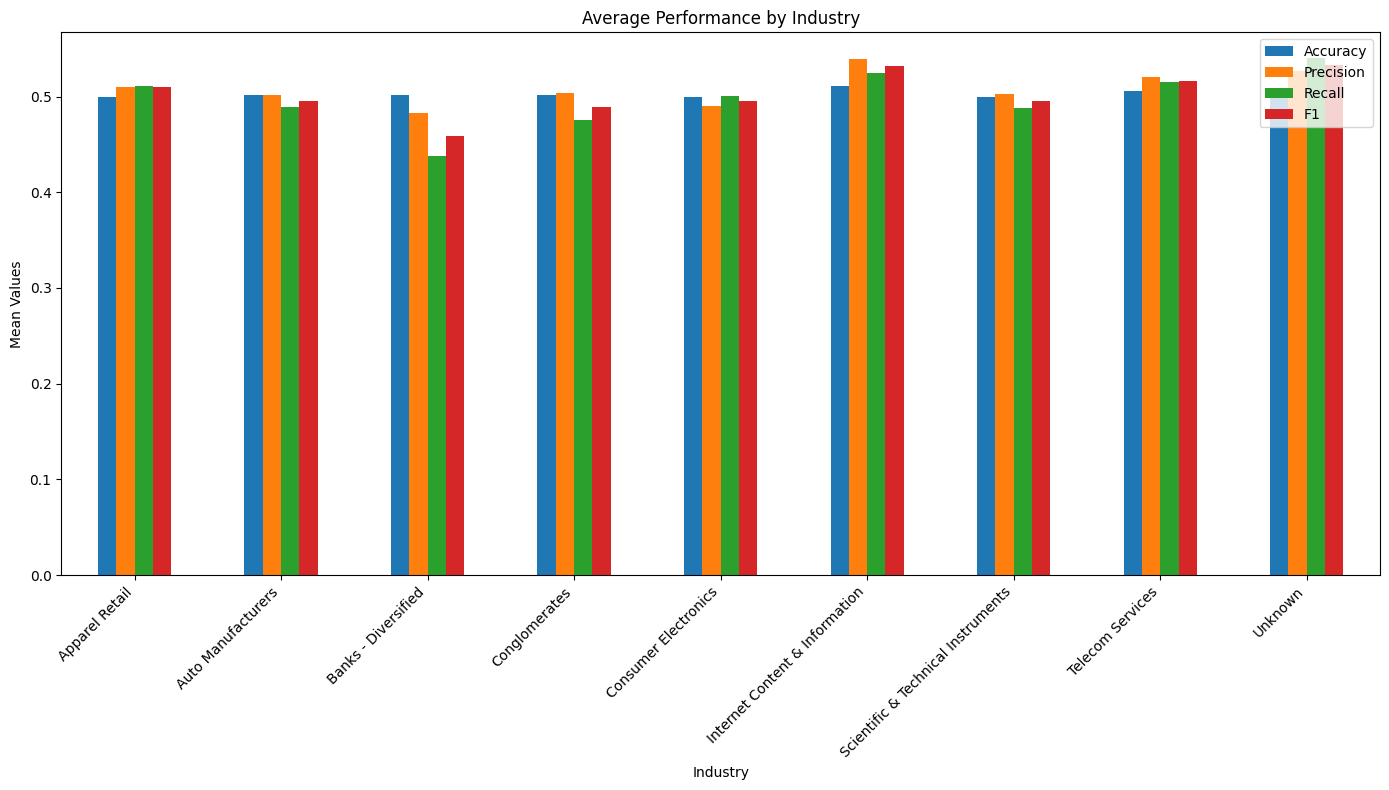

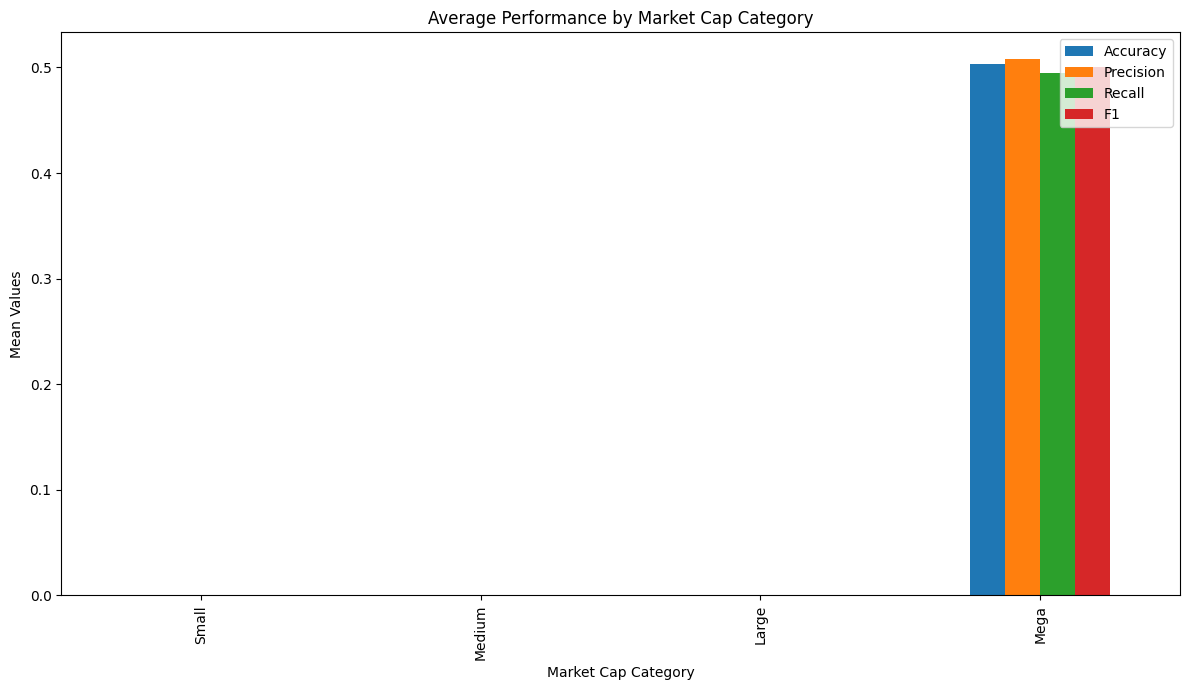

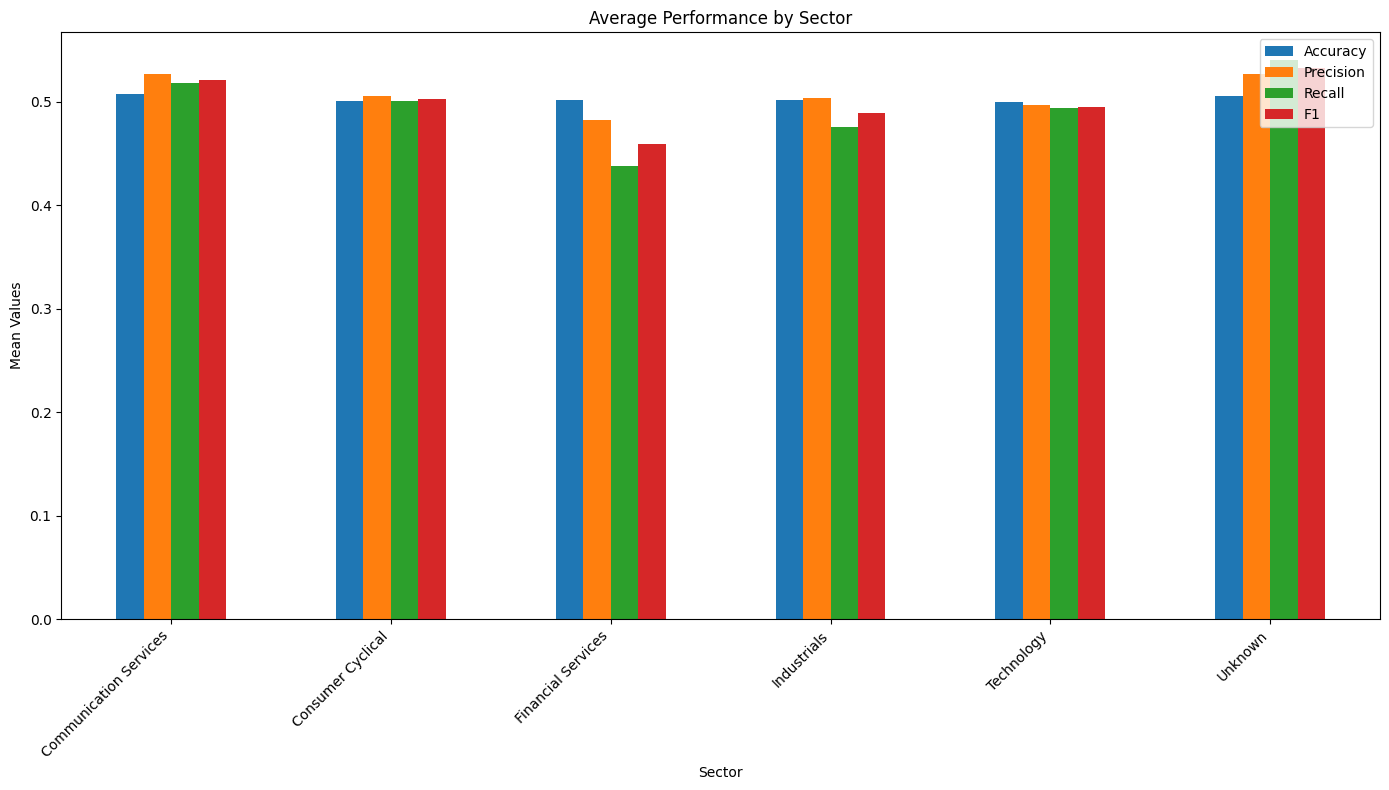

In [16]:
import matplotlib.pyplot as plt

# 可視化: 業界別の平均パフォーマンス
industry_performance.plot(kind='bar', figsize=(14, 8), title='Average Performance by Industry')
plt.ylabel('Mean Values')
plt.xlabel('Industry')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 可視化: 時価総額カテゴリ別の平均パフォーマンス
market_cap_performance.plot(kind='bar', figsize=(12, 7), title='Average Performance by Market Cap Category')
plt.ylabel('Mean Values')
plt.xlabel('Market Cap Category')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 可視化: セクター別の平均パフォーマンス
sector_performance.plot(kind='bar', figsize=(14, 8), title='Average Performance by Sector')
plt.ylabel('Mean Values')
plt.xlabel('Sector')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


業界や時価総額ごとの分析

In [15]:
# 時価総額をカテゴリ化
results_with_industry['Market_Cap_Category'] = pd.cut(
    results_with_industry['Market_Cap'],
    bins=[0, 1e10, 5e10, 1e11, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Mega']
)

# 業界別の平均パフォーマンス
industry_performance = results_with_industry.groupby('Industry')[
    ['Accuracy', 'Precision', 'Recall', 'F1']
].mean()

# 時価総額カテゴリ別の平均パフォーマンス
market_cap_performance = results_with_industry.groupby('Market_Cap_Category')[
    ['Accuracy', 'Precision', 'Recall', 'F1']
].mean()

# セクター別の平均パフォーマンス
sector_performance = results_with_industry.groupby('Sector')[
    ['Accuracy', 'Precision', 'Recall', 'F1']
].mean()

# データ表示
import ace_tools as tools; tools.display_dataframe_to_user(name="Industry Performance", dataframe=industry_performance)
tools.display_dataframe_to_user(name="Market Cap Performance", dataframe=market_cap_performance)
tools.display_dataframe_to_user(name="Sector Performance", dataframe=sector_performance)


ModuleNotFoundError: No module named 'ace_tools'

Results saved to evaluation_results.csv


エラーしたticker止まるやつ

In [ ]:
for ticker in tickers:
    print(f"Processing ticker: {ticker}...")
    ticker_start_time = time.time()

    # データ取得
    stock = yf.Ticker(ticker)
    data_master = stock.history(start=start, end=end)

    # 欠損値除去
    data = data_master.dropna().copy()

    # 対数差分計算用関数
    def log_diff(series):
        return np.log(series) - np.log(series.shift(1))

    # OHLCVに対して対数差分を計算
    data["LogDiff_Open"] = log_diff(data["Open"])
    data["LogDiff_High"] = log_diff(data["High"])
    data["LogDiff_Low"] = log_diff(data["Low"])
    data["LogDiff_Close"] = log_diff(data["Close"])
    data["LogDiff_Volume"] = log_diff(data["Volume"])

    # 終値の階差特徴量
    data["Close_diff_2"] = data["Close"] - data["Close"].shift(2)
    data["Close_diff_4"] = data["Close"] - data["Close"].shift(4)
    data["Close_diff_8"] = data["Close"] - data["Close"].shift(8)
    data["Close_diff_16"] = data["Close"] - data["Close"].shift(16)

    # ラベル作成
    data["future_close"] = data["Close"].shift(-16)
    data["next_open"] = data["Open"].shift(-15)
    data["y_label"] = (data["future_close"] > data["next_open"]).astype(int)

    # Haarフィルター定義
    h = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
    g = np.array([1/np.sqrt(2), -1/np.sqrt(2)])

    v_current = data["Close"].values
    N = len(v_current)
    max_level = 4

    def line_index_for_level(j, t):
        return (2**j - 1) + (2**j)*t

    for j in range(1, max_level+1):
        length_prev = len(v_current)
        length_new = length_prev // 2

        v_j = np.zeros(length_new)
        w_j = np.zeros(length_new)

        for t in range(length_new):
            v_j[t] = g[0]*v_current[2*t] + g[1]*v_current[2*t+1]
            w_j[t] = h[0]*v_current[2*t] + h[1]*v_current[2*t+1]

        w_col = np.full(N, np.nan)
        v_col = np.full(N, np.nan)

        for t in range(length_new):
            idx = line_index_for_level(j, t)
            if idx < N:
                w_col[idx] = w_j[t]
                v_col[idx] = v_j[t]
            else:
                break

        data[f"w_{j}"] = w_col
        data[f"v_{j}"] = v_col

        v_current = v_j

    # 不要列削除
    data = data.drop(columns=["future_close", "next_open"])
    # 前方補間
    data = data.ffill()

    # InfをNaNに
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # NaNを0で埋める
    data = data.fillna(0)

    X_all = data
    y = data["y_label"].values

    # 分割器
    tscv = TimeSeriesSplit(n_splits=30)

    # 特徴量セット毎に評価
    for set_name, feature_cols in feature_sets.items():
        print(f"  Evaluating feature set: {set_name}...")
        feature_start_time = time.time()

        # 特徴量抽出
        X = X_all[feature_cols].astype(float).values

        all_predictions = []
        all_actual = []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = XGBClassifier(eval_metric='logloss')
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            all_predictions.extend(preds)
            all_actual.extend(y_test)

        feature_end_time = time.time()

        all_predictions = np.array(all_predictions)
        all_actual = np.array(all_actual)

        accuracy = accuracy_score(all_actual, all_predictions)
        precision = precision_score(all_actual, all_predictions, zero_division=0)
        recall = recall_score(all_actual, all_predictions, zero_division=0)
        f1 = f1_score(all_actual, all_predictions, zero_division=0)

        results.append({
            "Ticker": ticker,
            "Feature_Set": set_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Execution_Time(sec)": feature_end_time - feature_start_time
        })

    ticker_end_time = time.time()
    print(f"Finished processing ticker: {ticker}. Time taken: {ticker_end_time - ticker_start_time:.2f} seconds")

# 処理終了
overall_end_time = time.time()
print(f"All processing completed. Total time taken: {overall_end_time - overall_start_time:.2f} seconds")

# 結果をDataFrameに
results_df = pd.DataFrame(results)

# 表示
print(results_df)